# Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

from sklearn.model_selection import KFold, train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, SensitivityAtSpecificity, SpecificityAtSensitivity, Precision, Recall, AUC
from keras.utils import to_categorical
import cv2
from PIL import Image
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten, Activation, AveragePooling2D

In [4]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Classes

In [5]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'No passing for > 3.5 tons' }

NUMBER_OF_CLASSES = len(classes)

## Getting the data from the images

In [6]:
X = []
y = []

for i in range(NUMBER_OF_CLASSES):
    path = "./Data/archive//train/" + str(i)
    images = os.listdir(path)

    for img in images:
      image = cv2.imread(path + '/' + img)
      image_fromarray = Image.fromarray(image, 'RGB')
      resize_image = image_fromarray.resize((30, 30))
      X.append(np.array(resize_image))
      y.append(i)


# putting it into numpy
X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)

(39209, 30, 30, 3) (39209,)


## Splitting and scaling

Speed limit (70km/h)


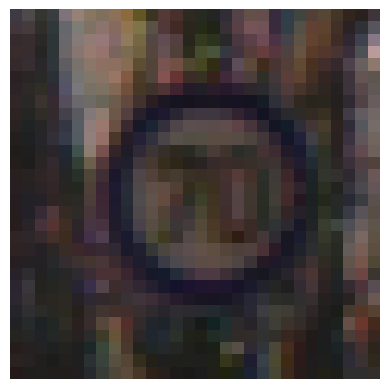

In [7]:
i = random.randint(0,X.shape[0])
plt.imshow(X[i])
print(classes.get(y[i]))
plt.axis('off')
plt.show()

## Convert targets into categorical values

In [8]:
y = keras.utils.to_categorical(y, NUMBER_OF_CLASSES)

# Build CNNs

In [9]:
#data augmentation for better results
img_aug = ImageDataGenerator(
    rotation_range=7,
    zoom_range=0.14,
    width_shift_range=0.05,
    height_shift_range=0.2,
    shear_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

In [10]:
kf = KFold(10, shuffle=True)

In [11]:
table = pd.DataFrame()

## LeNet5

In [14]:
checkpoint_path = "LeNet/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

metric_history = pd.DataFrame()
i=1
model = keras.models.Sequential()
for train_index, test_index in kf.split(X):
    X_kf, X_cv = X[train_index], X[test_index]
    y_kf, y_cv = y[train_index], y[test_index]

    print(i)
    i=i+1

    model = keras.models.Sequential([
        Conv2D(filters=6, kernel_size=(5,5), padding='same', activation='tanh', input_shape=(30, 30, 3)),
        AveragePooling2D(strides=(2,2)),
        Conv2D(filters=16, kernel_size=(5,5), padding='valid', activation='tanh'),
        AveragePooling2D(strides=(2,2)),
        Conv2D(filters=120, kernel_size=(1,1), padding='valid', activation='tanh'),
        Flatten(),
        Dense(84, activation='relu'),
        Dense(NUMBER_OF_CLASSES, activation='softmax'),
    ])
    
    model.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics=["accuracy", TruePositives(), FalsePositives(), TrueNegatives(), FalseNegatives(), SensitivityAtSpecificity(0.5), SpecificityAtSensitivity(0.5), Precision(), Recall(), AUC()])


    history = model.fit(img_aug.flow(X_kf, y_kf, batch_size=512), validation_data=[X_cv, y_cv], epochs=20, verbose=1, callbacks=[cp_callback],)

    loss, accuracy, tp, fp, tn, fn, sensitivity, specificity, precision, recall, auc = model.evaluate(X_cv, y_cv)
    metrics = pd.DataFrame([[loss, accuracy, tp, fp, tn, fn, sensitivity, specificity, precision, recall, auc]], columns=["Loss", "Accuracy", "TP", "FP", "TN", "FN", "Sensitivity","Specificity", "Precision", "Recall", "AUC"])
    metric_history = pd.concat([metric_history, metrics], ignore_index=True)
print(metric_history.mean())
info = pd.DataFrame([["LeNet 5"]], columns=["Topology", ])
info = pd.concat([info, pd.DataFrame(metric_history.mean()).T], axis=1,)
table = pd.concat([table, info], ignore_index=True)



1
Epoch 1/20
69/69 [==============================] - ETA: 0s - loss: 2.6143 - accuracy: 0.2955 - true_positives_1: 3044.0000 - false_positives_1: 604.0000 - true_negatives_1: 1481492.0000 - false_negatives_1: 32244.0000 - sensitivity_at_specificity_1: 0.9359 - specificity_at_sensitivity_1: 0.9419 - precision_1: 0.8344 - recall_1: 0.0863 - auc_1: 0.8676
Epoch 1: saving model to LeNet\cp.ckpt
69/69 [==============================] - 12s 156ms/step - loss: 2.6143 - accuracy: 0.2955 - true_positives_1: 3044.0000 - false_positives_1: 604.0000 - true_negatives_1: 1481492.0000 - false_negatives_1: 32244.0000 - sensitivity_at_specificity_1: 0.9359 - specificity_at_sensitivity_1: 0.9419 - precision_1: 0.8344 - recall_1: 0.0863 - auc_1: 0.8676 - val_loss: 1.4648 - val_accuracy: 0.5669 - val_true_positives_1: 1184.0000 - val_false_positives_1: 107.0000 - val_true_negatives_1: 164575.0000 - val_false_negatives_1: 2737.0000 - val_sensitivity_at_specificity_1: 0.9941 - val_specificity_at_sensitivit

In [15]:
table.to_csv("./log.csv")

## AlexNet

In [34]:
checkpoint_path = "AlexNet/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
metric_history = pd.DataFrame()
i=1
for train_index, test_index in kf.split(X):
    X_kf, X_cv = X[train_index], X[test_index]
    y_kf, y_cv = y[train_index], y[test_index]

    print(i)
    i=i+1

    model = keras.models.Sequential([
        Conv2D(filters=256, kernel_size=(5,5), padding='same', activation='relu', input_shape=(30, 30, 3)),
        MaxPool2D(pool_size=(3,3), strides=(2,2)),
        Conv2D(filters=256, kernel_size=(3,3), padding='valid', activation='relu'),
        MaxPool2D(pool_size=(3,3), strides=(2,2)),
        Flatten(),
        Dense(4096, activation='relu'),
        Dense(NUMBER_OF_CLASSES, activation='softmax'),
    ])
    
    model.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics=["accuracy", TruePositives(), FalsePositives(), TrueNegatives(), FalseNegatives(), SensitivityAtSpecificity(0.5), SpecificityAtSensitivity(0.5), Precision(), Recall(), AUC()])


    history = model.fit(img_aug.flow(X_kf, y_kf, batch_size=256), validation_data=[X_cv, y_cv], epochs=20, verbose=1, callbacks=[cp_callback],)

    loss, accuracy, tp, fp, tn, fn, sensitivity, specificity, precision, recall, auc = model.evaluate(X_cv, y_cv)
    metrics = pd.DataFrame([[loss, accuracy, tp, fp, tn, fn, sensitivity, specificity, precision, recall, auc]], columns=["Loss", "Accuracy", "TP", "FP", "TN", "FN", "Sensitivity","Specificity", "Precision", "Recall", "AUC"])
    metric_history = pd.concat([metric_history, metrics], ignore_index=True)
print(metric_history.mean())
info = pd.DataFrame([["AlexNet"]], columns=["Topology", ])
info = pd.concat([info, pd.DataFrame(metric_history.mean()).T], axis=1,)
table = pd.concat([table, info], ignore_index=True)

1
Epoch 1/20
138/138 [==============================] - ETA: 0s - loss: 7.6237 - accuracy: 0.2225 - true_positives_13: 1924.0000 - false_positives_13: 2141.0000 - true_negatives_13: 1479955.0000 - false_negatives_13: 33364.0000 - sensitivity_at_specificity_13: 0.8699 - specificity_at_sensitivity_13: 0.8963 - precision_13: 0.4733 - recall_13: 0.0545 - auc_13: 0.8073
Epoch 1: saving model to AlexNet\cp.ckpt
138/138 [==============================] - 25s 144ms/step - loss: 7.6237 - accuracy: 0.2225 - true_positives_13: 1924.0000 - false_positives_13: 2141.0000 - true_negatives_13: 1479955.0000 - false_negatives_13: 33364.0000 - sensitivity_at_specificity_13: 0.8699 - specificity_at_sensitivity_13: 0.8963 - precision_13: 0.4733 - recall_13: 0.0545 - auc_13: 0.8073 - val_loss: 2.0438 - val_accuracy: 0.4241 - val_true_positives_13: 683.0000 - val_false_positives_13: 219.0000 - val_true_negatives_13: 164463.0000 - val_false_negatives_13: 3238.0000 - val_sensitivity_at_specificity_13: 0.9847 -

FailedPreconditionError: {{function_node __wrapped__MergeV2Checkpoints_device_/job:localhost/replica:0/task:0/device:CPU:0}} Failed to rename: AlexNet\cp.ckpt_temp/part-00000-of-00001.data-00000-of-00001 to: AlexNet\cp.ckpt.data-00000-of-00001 : The process cannot access the file because it is being used by another process.
; Broken pipe [Op:MergeV2Checkpoints]

In [ ]:
table.to_csv("./log.csv")

In [ ]:
table

## Visualize features

In [20]:
checkpoint_path = "LeNet/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


# summarize filters in each convolutional layer
from matplotlib import pyplot

model = keras.models.Sequential([
        Conv2D(filters=6, kernel_size=(5,5), padding='same', activation='tanh', input_shape=(30, 30, 3)),
        AveragePooling2D(strides=(2,2)),
        Conv2D(filters=16, kernel_size=(5,5), padding='valid', activation='tanh'),
        AveragePooling2D(strides=(2,2)),
        Conv2D(filters=120, kernel_size=(1,1), padding='valid', activation='tanh'),
        Flatten(),
        Dense(84, activation='relu'),
        Dense(NUMBER_OF_CLASSES, activation='softmax'),
    ])
model.load_weights(checkpoint_path)

model.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics=["accuracy",])

loss, acc = model.evaluate(X, y, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))


# summarize filter shapes
for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

1226/1226 - 3s - loss: 0.1352 - accuracy: 0.9615 - 3s/epoch - 3ms/step
Restored model, accuracy: 96.15%
conv2d_41 (5, 5, 3, 6)
conv2d_42 (5, 5, 6, 16)
conv2d_43 (1, 1, 16, 120)


0


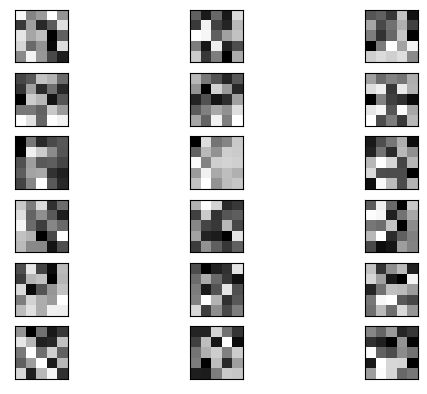

2


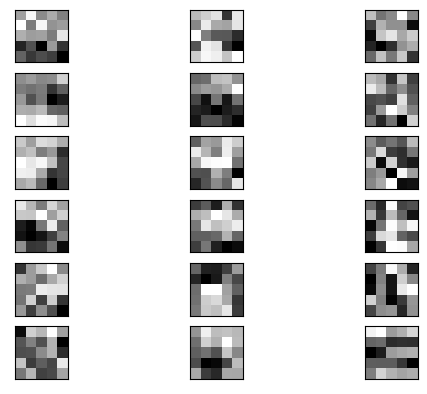

In [33]:
for l in range(0, 4, 2):
    # retrieve weights from the second hidden layer
    filters, biases = model.layers[l].get_weights()
    # normalize filter values to 0-1 so we can visualize them
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    # plot first few filters
    n_filters, ix = 6, 1
    for i in range(n_filters):
        # get the filter
        f = filters[:, :, :, i]
        # plot each channel separately
        for j in range(3):
            # specify subplot and turn of axis
            ax = pyplot.subplot(n_filters, 3, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(f[:, :, j], cmap='gray')
            ix += 1
    # show the figure
    pyplot.show()

In [ ]:
checkpoint_path = "AlexNet/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


# summarize filters in each convolutional layer
from matplotlib import pyplot

model = keras.models.Sequential([
        Conv2D(filters=256, kernel_size=(5,5), padding='same', activation='relu', input_shape=(30, 30, 3)),
        MaxPool2D(pool_size=(3,3), strides=(2,2)),
        Conv2D(filters=256, kernel_size=(3,3), padding='valid', activation='relu'),
        MaxPool2D(pool_size=(3,3), strides=(2,2)),
        Flatten(),
        Dense(4096, activation='relu'),
        Dense(NUMBER_OF_CLASSES, activation='softmax'),
    ])

model.load_weights(checkpoint_path)

model.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics=["accuracy",])

loss, acc = model.evaluate(X, y, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))


# summarize filter shapes
for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

In [ ]:
for l in range(0, 4, 2):
    # retrieve weights from the second hidden layer
    filters, biases = model.layers[l].get_weights()
    # normalize filter values to 0-1 so we can visualize them
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    # plot first few filters
    n_filters, ix = 6, 1
    for i in range(n_filters):
        # get the filter
        f = filters[:, :, :, i]
        # plot each channel separately
        for j in range(3):
            # specify subplot and turn of axis
            ax = pyplot.subplot(n_filters, 3, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(f[:, :, j], cmap='gray')
            ix += 1
    # show the figure
    pyplot.show()